#Bandwidth Selection for Kernel Density Estimation
In this notebook we automate the process of bandwidth selection for KDE 

In [2]:
!pip install KDEpy

     |████████████████████████████████| 420 kB 5.0 MB/s 


In [3]:
import numpy as np
from scipy.stats import weibull_max
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
import KDEpy
import sklearn
import math
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KernelDensity

In [34]:
class KDEBandwidthSelector:

    def __init__(self, data) -> None:
        X_train, X_test = train_test_split(data, test_size=0.3, random_state=42)
        self.train = X_train
        self.test = X_test

    def is_normal_dist(self, significance=0.05):
        '''The function recieves a significance value (alpha) and checks if the data is from a normal distribution with KS test. '''
        d, p_value = stats.kstest(self.train, 'norm')
        if p_value <= significance:
            return False
        return True

    def bw_silverman_method(self):
        g_kde = stats.gaussian_kde(dataset=self.train, bw_method='silverman')
        return g_kde.factor

    def bw_scott(self):
        g_kde = stats.gaussian_kde(dataset=self.train, bw_method='scott')
        return g_kde.factor

    def bw_sheather_jones(self):
        kdepy = KDEpy.FFTKDE(kernel='gaussian', bw='ISJ')
        if len(self.train.shape) != 2:
            if len(self.train.shape) == 1:
                train_data = np.reshape(self.train, (len(self.train), 1))
                bw = kdepy.bw_method(train_data)
                return bw
            else:
                raise Exception('Incorrect input dimension ')
        else:
            return kdepy.bw_method(self.train)
        # x,y = KDEpy.FFTKDE(kernel=kernal, bw= 'ISJ').fit(self.train).evaluate()
        # return x,y # check if we can return bw

    def bw_mlcv(self):
        # maximum 
        bandwidths = 10 ** np.linspace(-1, 1, 10)
        grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                            {'bandwidth': bandwidths},
                            cv=LeaveOneOut())
        grid.fit(self.train[:, None]);
        return grid.best_params_['bandwidth']

    def find_bw(self):
        '''The function searches and returns the bandwidth with the lowest KS statistic that does not reject the null hypothesis, 
            if all the bandwidth values reject the null hypothesis we return the bandsidth calculated by Improved Sheather and Jones method'''
        bw_values_dict = {}
        bw_values_dict['silverman'] = self.bw_silverman_method()
        bw_values_dict['scott'] = self.bw_scott()
        bw_values_dict['isj'] = self.bw_sheather_jones()
        bw_values_dict['mlcv'] = self.bw_mlcv()
        if not self.is_normal_dist():
        # silverman method works well only on normally distributed data
         del bw_values_dict['silverman']
        opt_bw = None
        opt_d_value = math.inf
        for key in bw_values_dict.keys():
            g_kde = stats.gaussian_kde(dataset=self.test, bw_method=bw_values_dict[key])
            cdf = lambda ary: np.array([g_kde.integrate_box_1d(-np.inf, x) for x in ary])
            d, p_val = stats.kstest(self.test, cdf)
            #print(f'{key}: D = {d},p_value = {p_val}')
            if p_val > 0.05:
                if d < opt_d_value:
                    opt_d_value = d
                    opt_bw = key
        if opt_bw is None:
          opt_bw = 'isj'
        return opt_bw, bw_values_dict[opt_bw]

#Experimenting
First, we try this on data generated from known distributions and then we continue to real world data

Normal Distribution 

In [39]:
sample_size = 10000
normal_samples= stats.norm.rvs(size=sample_size)


In [27]:
normal_bw_selector = KDEBandwidthSelector(normal_samples)

In [28]:
bw_method,normal_bw = normal_bw_selector.find_bw()

Visualizations

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.0685527177623045 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


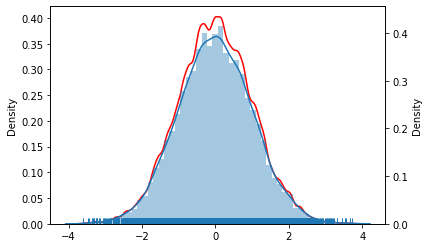

In [30]:
fig, ax = plt.subplots()

sns.kdeplot(normal_samples,bw=normal_bw,ax=ax,color='red')
ax2 = ax.twinx()
sns.distplot(normal_samples,rug=True,ax=ax2)


Exponential Distribution

In [49]:
exponential_samples = np.random.exponential(3.45, sample_size)

In [50]:
exponential_bw_selector = KDEBandwidthSelector(exponential_samples)

In [51]:
bw_method,exponential_bw = exponential_bw_selector.find_bw()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.04164887564789597 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


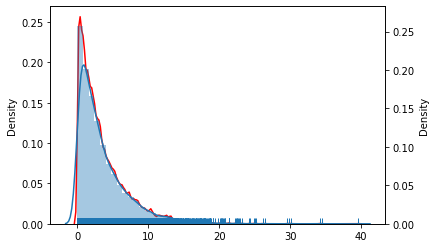

In [52]:
fig, ax = plt.subplots()

sns.kdeplot(exponential_samples,bw=exponential_bw,ax=ax,color='red')
ax2 = ax.twinx()
sns.distplot(exponential_samples,rug=True,ax=ax2)

The Boston House Price data

In [18]:
import pandas as pd
df= pd.read_csv('https://raw.githubusercontent.com/TamarRY/KDE-bandwidth-selector/main/boston.csv')
numeric_columns = df.dtypes[(df.dtypes=="float64")].index.tolist()
continuous_data=df[numeric_columns]
continuous_data

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.573,6.593,69.1,2.4786,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.573,6.120,76.7,2.2875,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.573,6.976,91.0,2.1675,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.573,6.794,89.3,2.3889,273.0,21.0,393.45,6.48,22.0


In [20]:
continuous_data.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554695,6.284634,68.574901,3.795043,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,711.000000,22.000000,396.900000,37.970000,50.000000


In [37]:
bw_dict = {}
for col in numeric_columns:
  bw_selector = KDEBandwidthSelector(continuous_data[col].values)
  bw_method,bw = bw_selector.find_bw()
  bw_dict[col] = bw


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.026166918850121876 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is depr

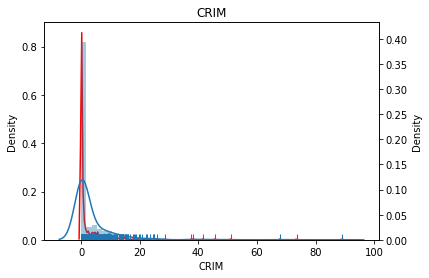

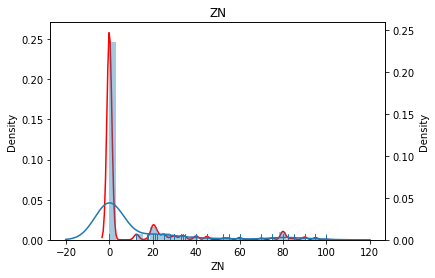

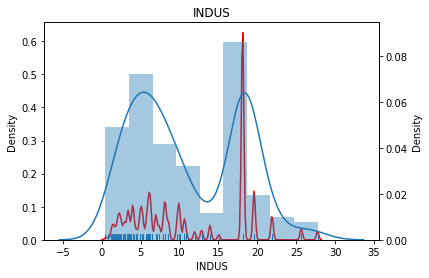

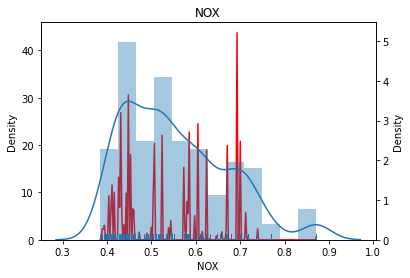

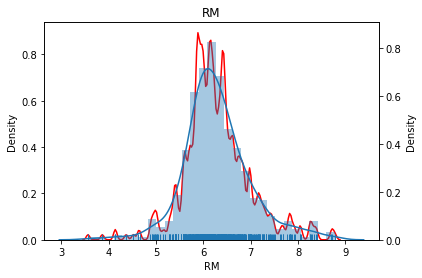

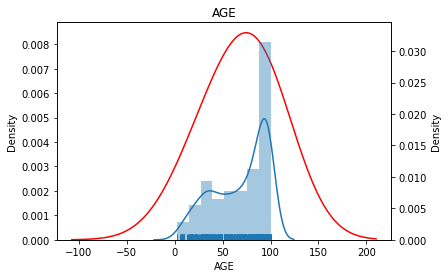

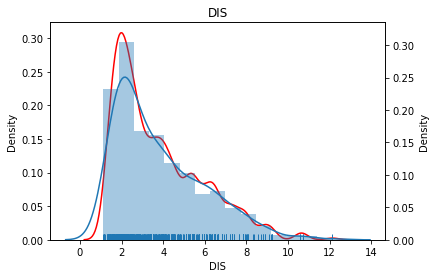

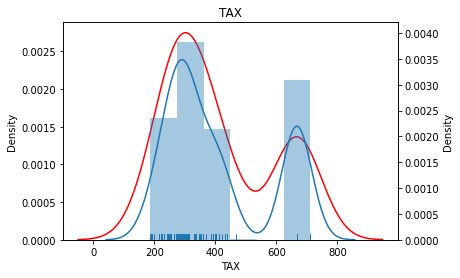

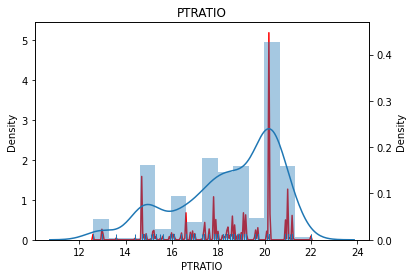

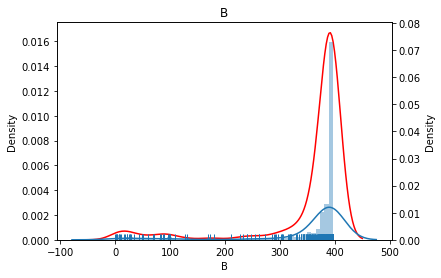

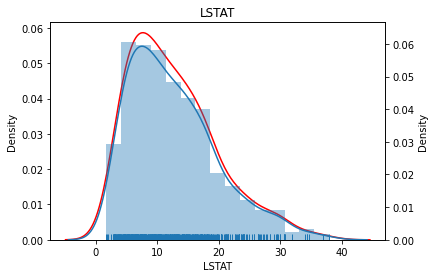

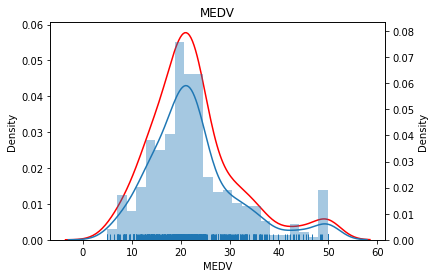

In [38]:
for col in numeric_columns:
  fig, ax = plt.subplots()
  sns.kdeplot(continuous_data[col],bw=bw_dict[col],ax=ax,color='red')
  ax2 = ax.twinx()
  sns.distplot(continuous_data[col],rug=True,ax=ax2).set(title=col)
